In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from copy import deepcopy
import time
import os
import copy

In [ ]:
from google.colab import files
uploaded = files.upload()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "val": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}


data_dir = 'drive/MyDrive/emotions'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x + "_class"),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
print(class_names)
ftrs = len (class_names)



['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [32]:
incept_model = models.inception_v3(pretrained=True)
incept_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [33]:
incept_model.aux_logits = False

for param in incept_model.parameters():
  param.requires_grad = False


incept_model.fc = nn.Sequential(nn.Linear(2048, 128), nn.ReLU(), nn.Linear(128, ftrs), nn.LogSoftmax(dim=1))

In [34]:
incept_model.to('cuda:0')

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [35]:
summary(incept_model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, incept_model.parameters()), lr=0.001)
tr_load = dataloaders['train']

def train_model(model, lossf, optim, epochs=15):
  model.train()
  hist = []
  for e in range(epochs):
    last_model = deepcopy(model)
    print(f"Epoch ", e + 1)


    train_loss = 0.
    # train_acc = 0.
    for i, (X, y) in enumerate(tr_load):
      X = X.to('cuda:0')
      y = y.to('cuda:0')

      optim.zero_grad()
      outputs = model(X)
      loss = lossf(outputs, y)
      loss.backward()
      optim.step()

      train_loss += loss.item() * X.size(0)
      
      if i % 20 == 0:
        print(i)
    
    trainloss = train_loss / len(image_datasets['train']) 
    print("TRAIN LOSS: ", trainloss)
    hist.append(trainloss)
  return model, hist


In [37]:
trained_model, hist_model = train_model(incept_model, loss_fn, optimizer, 3)

Epoch  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
20
40
60
TRAIN LOSS:  2.0283752003648483
Epoch  2
0
20
40
60
TRAIN LOSS:  1.9360628427431905
Epoch  3
0
20
40
60
TRAIN LOSS:  1.8784079053491647


In [38]:
def predict_fn(model, dataloader):

  all_preds = torch.tensor([]).to('cuda:0')
  true_vals = torch.tensor([]).to('cuda:0')

  with torch.no_grad():
    model.eval()

    for (X, y) in dataloader:
      X = X.to('cuda:0')
      y = y.to('cuda:0')

      all_preds = torch.cat((all_preds, model(X)), 0)
      true_vals = torch.cat((true_vals, y), 0)
      
  return all_preds, true_vals

In [40]:
trained_incept_model = trained_model.to('cuda:0')
outputs, labels = predict_fn(trained_incept_model, dataloaders['val'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Resnet

In [44]:
resnet_model = models.resnet152(pretrained=True)

for param in resnet_model.parameters():
  param.requires_grad = False

resnet_model.fc = nn.Sequential(nn.Linear(2048, 128), nn.ReLU(), nn.Linear(128, ftrs), nn.LogSoftmax(dim=1))

resnet_model.to('cuda:0')

summary(resnet_model, (3, 224, 224))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [45]:
resnet_model_trained, resnet_history = train_model(resnet_model, loss_fn, optimizer, 5)

Epoch  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
20
40
60
TRAIN LOSS:  2.033354226216806
Epoch  2
0
20
40
60
TRAIN LOSS:  1.9253071517416422
Epoch  3
0
20
40
60
TRAIN LOSS:  1.868352637198398
Epoch  4
0
20
40
60
TRAIN LOSS:  1.8271441795601424
Epoch  5
0
20
40
60
TRAIN LOSS:  1.784011414289303


In [46]:
resnet_model_trained = resnet_model_trained.to('cuda:0')
outputs_1, labels_1 = predict_fn(resnet_model_trained, dataloaders['val'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Results & ROC curves

Classification Report for Inception

In [52]:
_, outs = torch.max(outputs, dim=1)
print(classification_report(labels.cpu().numpy(), outs.cpu().numpy(), target_names=class_names))

              precision    recall  f1-score   support

       anger       0.21      0.17      0.19       400
    contempt       0.21      0.65      0.31       500
     disgust       0.24      0.08      0.12       500
        fear       0.20      0.75      0.31       400
       happy       0.63      0.06      0.11       500
     neutral       0.00      0.00      0.00       500
         sad       0.00      0.00      0.00       500
    surprise       0.27      0.07      0.11       500

    accuracy                           0.21      3800
   macro avg       0.22      0.22      0.14      3800
weighted avg       0.22      0.21      0.14      3800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for Inception

In [53]:
print(confusion_matrix(labels.cpu().numpy(), outs.cpu().numpy(), normalize='true'))

[[0.17   0.37   0.0725 0.3675 0.     0.     0.     0.02  ]
 [0.074  0.652  0.026  0.226  0.01   0.     0.     0.012 ]
 [0.142  0.43   0.082  0.31   0.006  0.     0.     0.03  ]
 [0.035  0.1425 0.0325 0.7525 0.0025 0.     0.     0.035 ]
 [0.046  0.538  0.05   0.262  0.058  0.     0.     0.046 ]
 [0.072  0.5    0.026  0.366  0.006  0.     0.     0.03  ]
 [0.122  0.4    0.052  0.404  0.     0.     0.     0.022 ]
 [0.042  0.242  0.016  0.622  0.01   0.     0.     0.068 ]]


ROC-curves

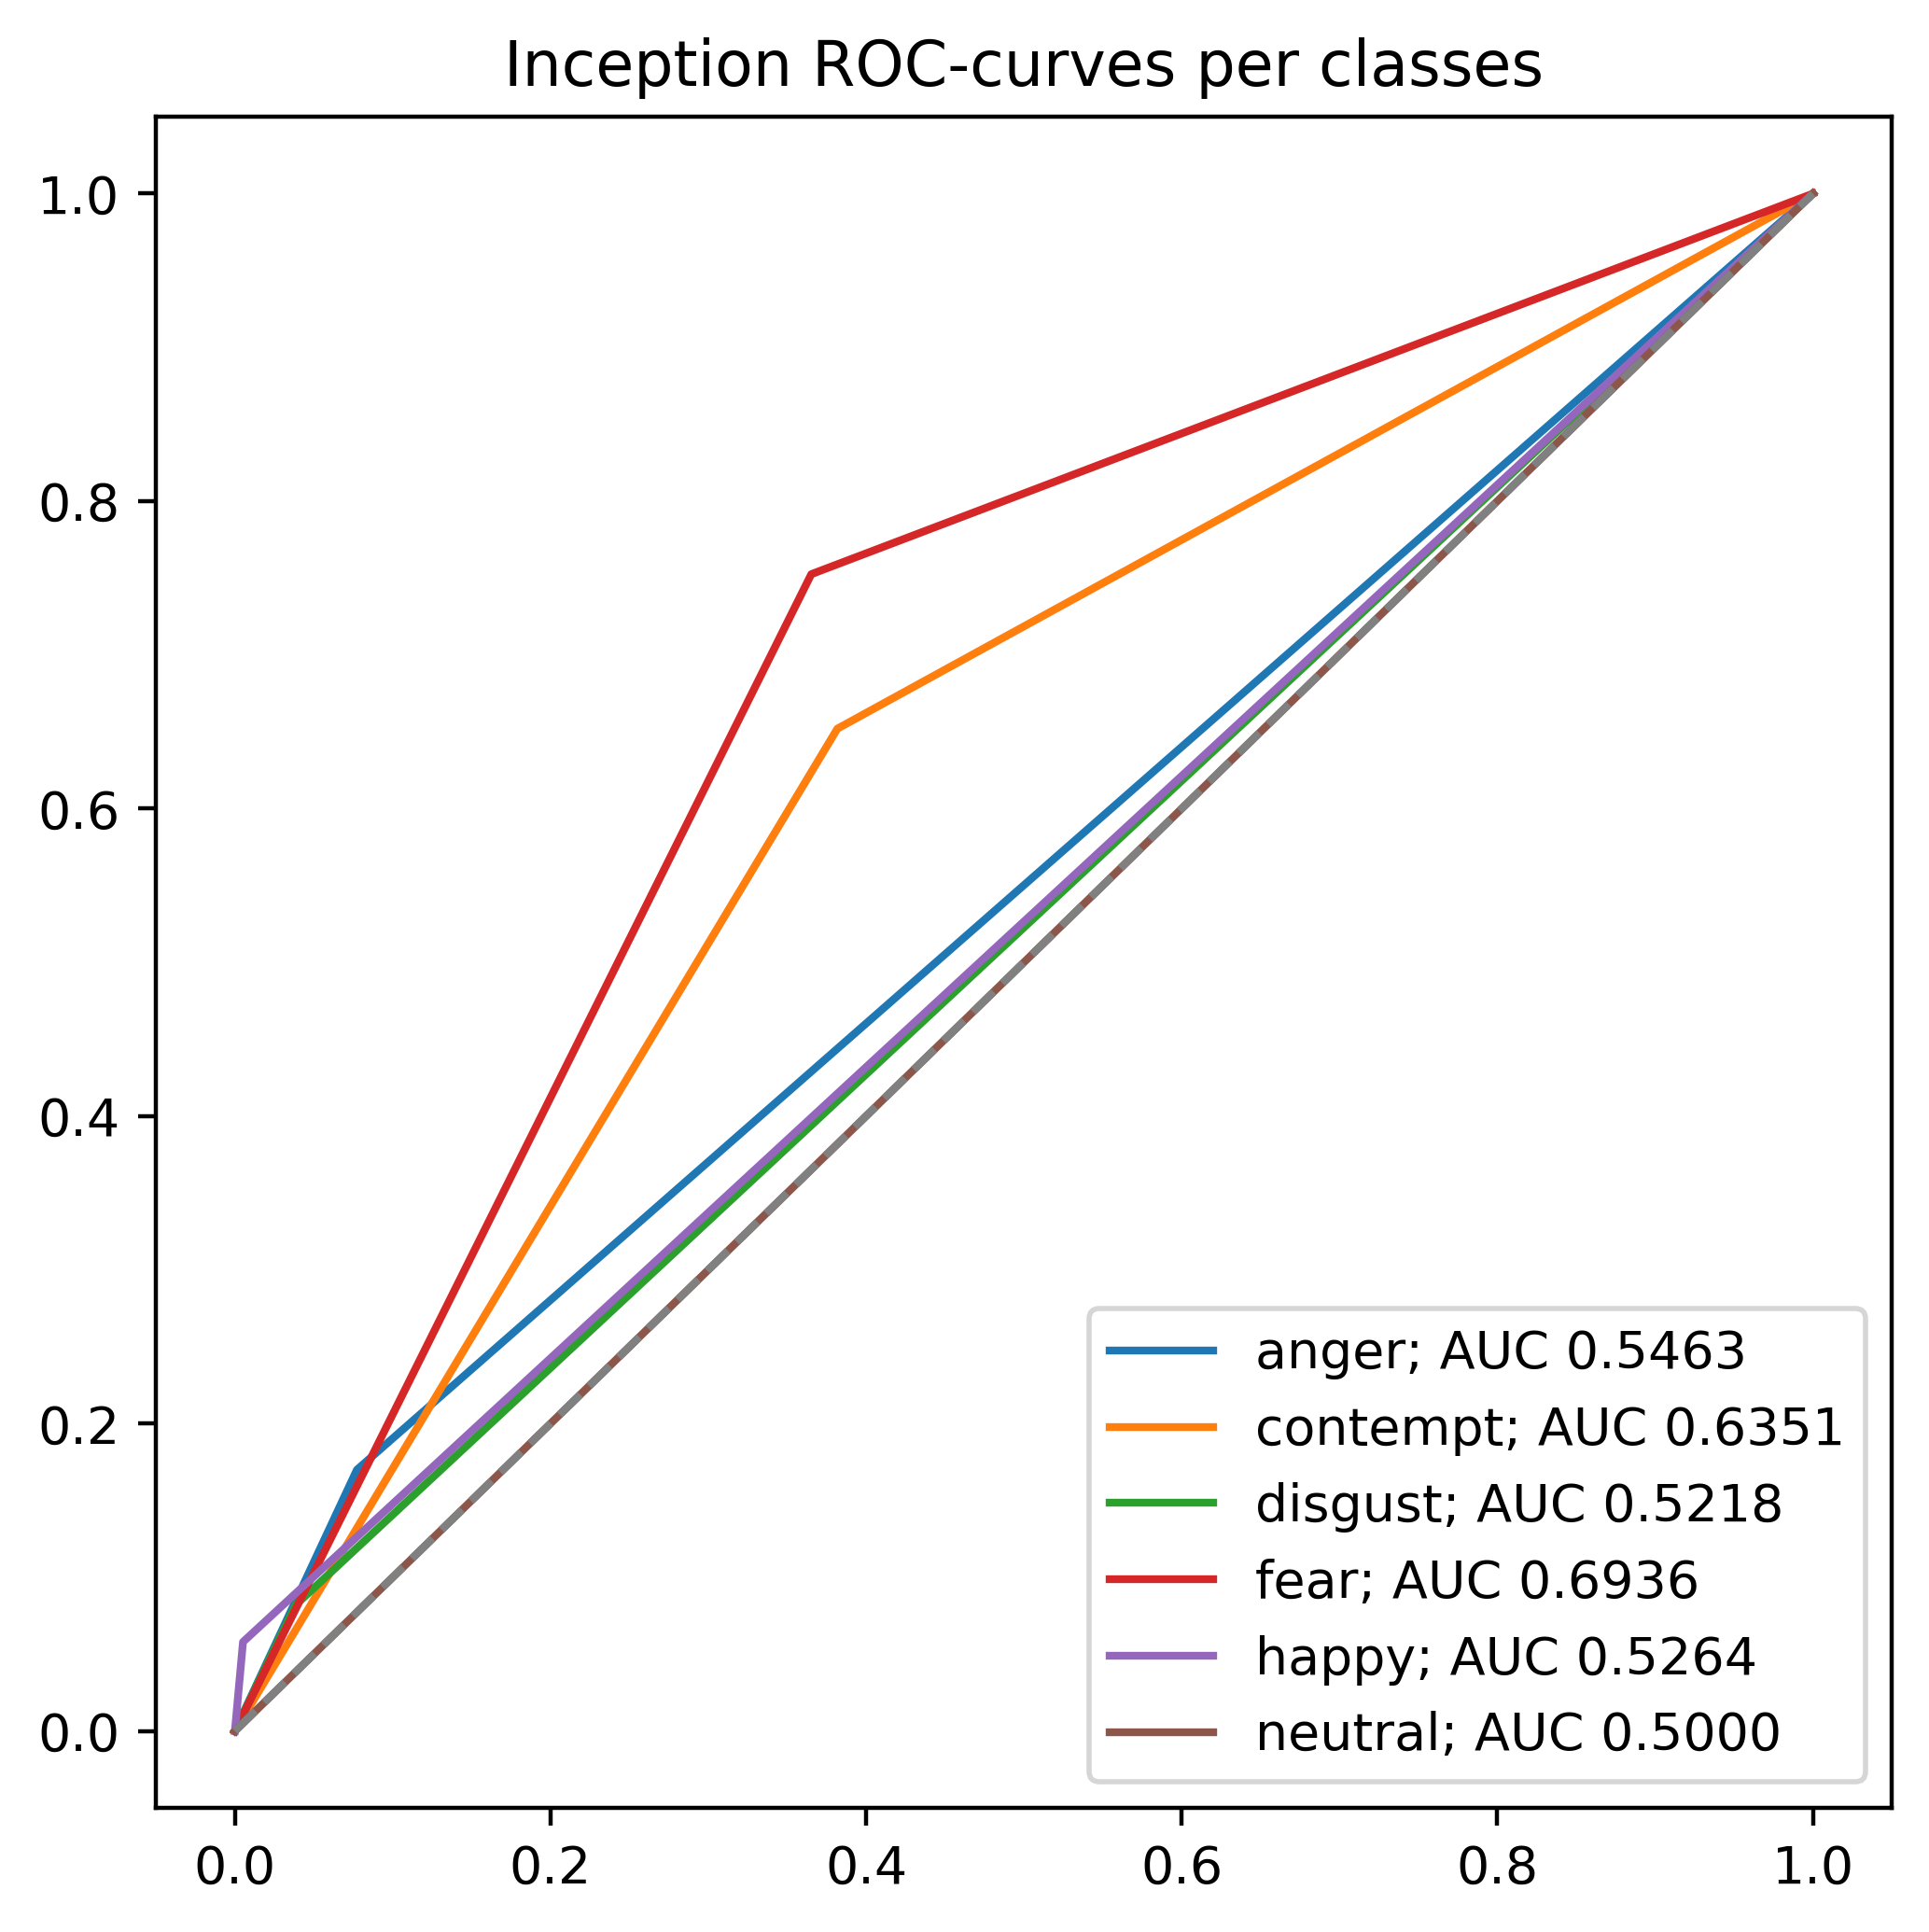

In [54]:
labels_plot = [(labels.cpu().numpy() == i).astype(float) for i in range(6)]
outs_plot = [(outs.cpu().numpy() == i).astype(float) for i in range(6)]
fpr_tpr = [roc_curve(labels_plot[i], outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]
fig = plt.figure(figsize=(6,6), dpi=400)
plt.title('Inception ROC-curves per classes')

for i in range(6):
  plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label = (class_names[i] + "; AUC " + "%.4f" % (roc_auc[i])))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color = "grey")
plt.show()

Classification Report for Resnet

In [47]:
_, outs = torch.max(outputs_1, dim=1)
print(classification_report(labels_1.cpu().numpy(), outs.cpu().numpy(), target_names=class_names))

              precision    recall  f1-score   support

       anger       0.22      0.20      0.21       400
    contempt       0.20      0.74      0.32       500
     disgust       0.27      0.06      0.10       500
        fear       0.27      0.64      0.37       400
       happy       0.39      0.15      0.21       500
     neutral       0.26      0.14      0.18       500
         sad       0.00      0.00      0.00       500
    surprise       0.32      0.06      0.10       500

    accuracy                           0.24      3800
   macro avg       0.24      0.25      0.19      3800
weighted avg       0.24      0.24      0.18      3800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for Resnet

In [48]:
print (confusion_matrix(labels_1.cpu().numpy(), outs.cpu().numpy(), normalize='true'))

[[0.195  0.4825 0.05   0.1775 0.0125 0.065  0.     0.0175]
 [0.056  0.74   0.01   0.084  0.044  0.062  0.     0.004 ]
 [0.166  0.438  0.058  0.192  0.056  0.068  0.     0.022 ]
 [0.07   0.2125 0.01   0.635  0.02   0.03   0.     0.0225]
 [0.034  0.592  0.028  0.122  0.148  0.052  0.     0.024 ]
 [0.054  0.59   0.012  0.16   0.02   0.136  0.     0.028 ]
 [0.13   0.454  0.052  0.26   0.014  0.07   0.     0.02  ]
 [0.054  0.302  0.006  0.442  0.072  0.064  0.     0.06  ]]


ROC-curves

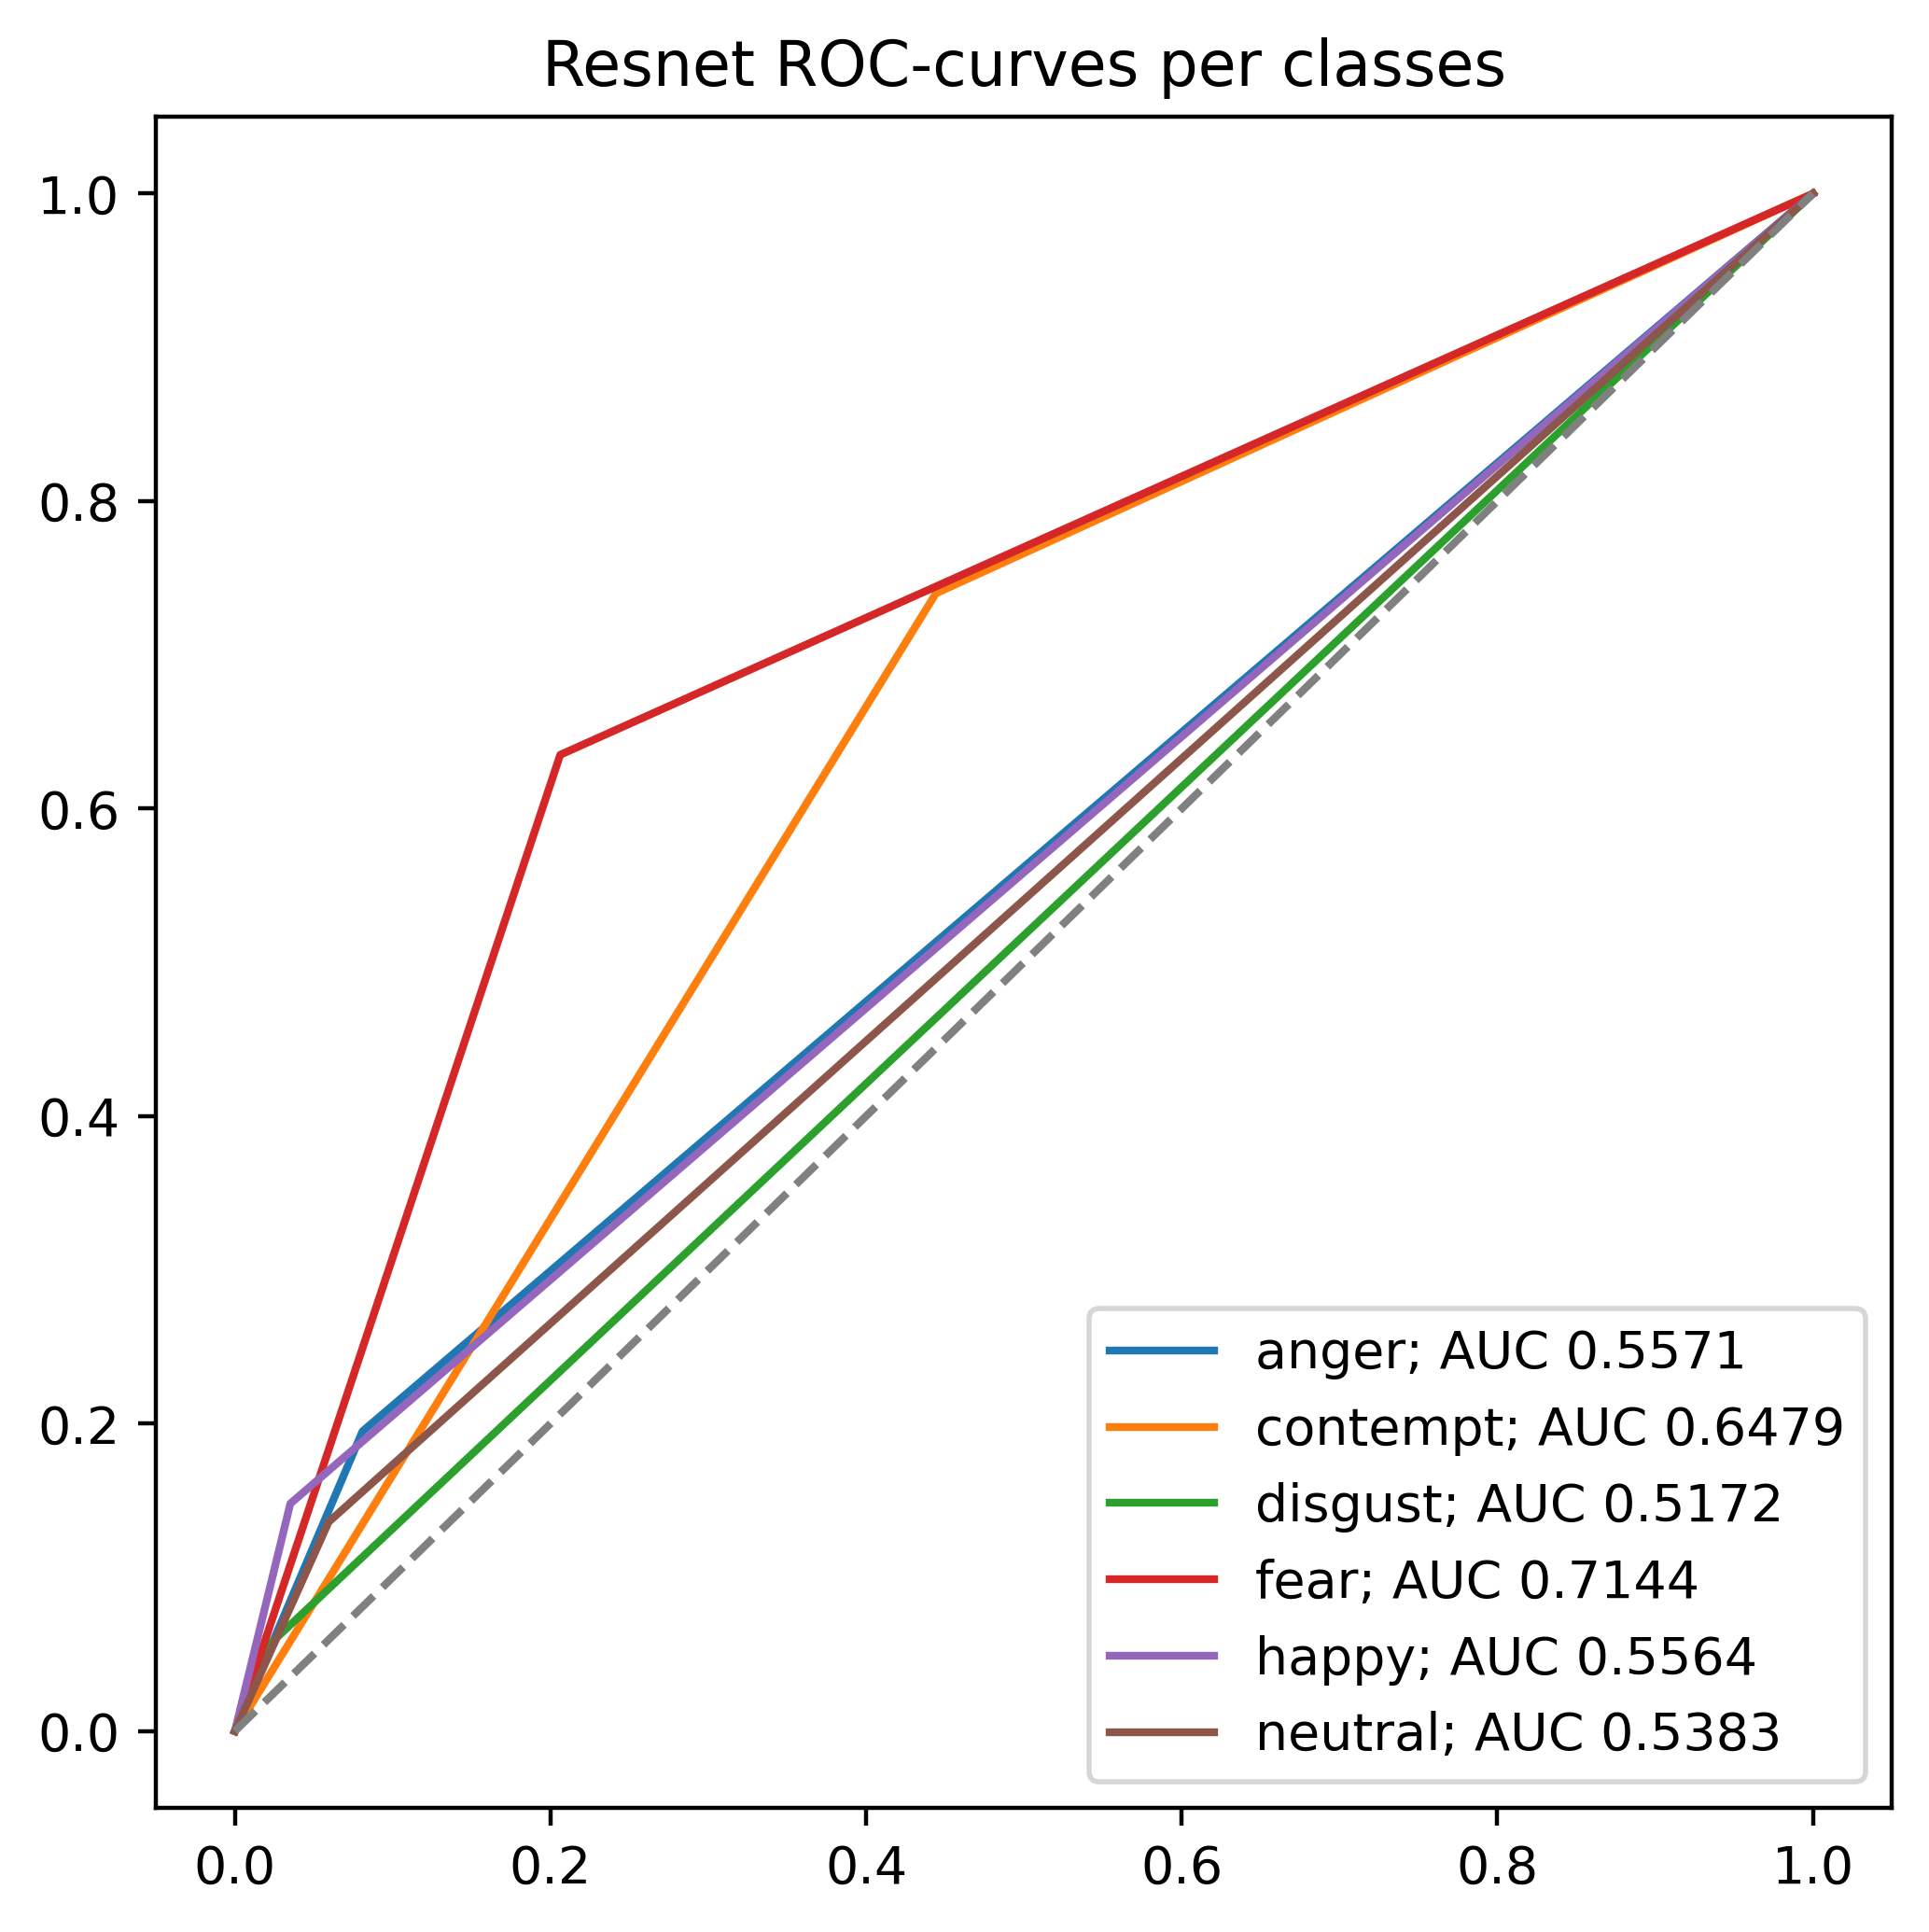

In [50]:
labels_plot = [(labels_1.cpu().numpy() == i).astype(float) for i in range(6)]
outs_plot = [(outs.cpu().numpy() == i).astype(float) for i in range(6)]
fpr_tpr = [roc_curve(labels_plot[i], outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]
fig = plt.figure(figsize=(6,6), dpi=400)
plt.title('Resnet ROC-curves per classes')

for i in range(6):
  plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label = (class_names[i] + "; AUC " + "%.4f" % (roc_auc[i])))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color = "grey")
plt.show()

MobileNet visualisation

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


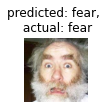

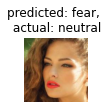

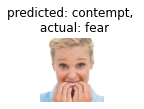

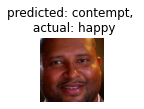

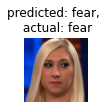

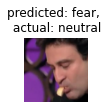

In [57]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to("cuda:0")
            labels = labels.to("cuda:0")

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, \n actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(trained_model, num_images=6)

VGG visualisation

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


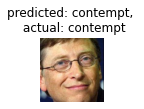

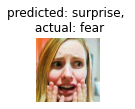

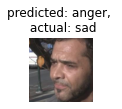

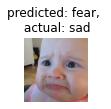

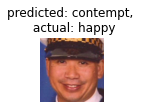

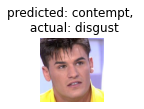

In [59]:
visualize_model(resnet_model_trained, num_images=6)

# Conclusion
As a result, we get not the most productive model. Both in the first case (Inception), and in the second (Resnet). Classification is worse than for example with landscapes. The fact is that pictures from different classes (landscapes) had very pronounced features (the city and the forest are radically different in the structure of the photograph) for their classes. Here, in all the photographs, there are faces, and the difference is essentially only in facial expressions. In addition, people have different faces. It also affects the fact that different resolutions of photos, different colors.

In addition, the description of the emotions themselves for most of the photographs is very ambiguous, from my point of view.